# Purpose of this simulation


# ideas

In [1]:

#for comparision
exp_conds = ['w/o feature selection', 
             'w/ iter feature selection',
            'w/o start with high SNR neurons']

for e in exp_conds: print(e)


w/o feature selection
w/ iter feature selection
w/o start with high SNR neurons


# Experimental setup related to the questions

this part should be configured to directly test the hypothesis put forward in the previous section


In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)

mean_firing_rate_low = 50
mean_firing_rate_high = 100

noise_mode = 'fixed_gaussian'
fixed_noise_level = 5 #Hz

In [3]:


neuron_types = ['noisy', 'non_noisy']

n_neurons = 32
n_neurons_noisy_group = 24
n_neurons_no_noise_group = 8


noise_neuron_ind = np.arange(n_neurons_noisy_group)
no_noise_neuron_ind = np.arange(n_neurons_noisy_group, n_neurons_noisy_group + n_neurons_no_noise_group)

neuron_type_indices_in_a_list = [
    noise_neuron_ind, 
    no_noise_neuron_ind
]


noise_neuron_list = np.full(n_neurons, False, dtype = bool)
no_noise_neuron_list = np.full(n_neurons, False, dtype = bool)


noise_neuron_list[noise_neuron_ind] = True
no_noise_neuron_list[no_noise_neuron_ind] = True



neuron_type_bool_list = [
    noise_neuron_list,
    no_noise_neuron_list,
]

N_TYPES_OF_NEURONS = 2

print('We have two types of indices: ')
for t,l in enumerate(neuron_type_indices_in_a_list): print(f'{neuron_types[t]}:{l}')


We have two types of indices: 
noisy:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
non_noisy:[24 25 26 27 28 29 30 31]


In [4]:
percent_of_count = np.ones(n_neurons)[:, np.newaxis]
print(f'set up the variances in a list:')

percent_of_count[noise_neuron_ind] =  1
percent_of_count[no_noise_neuron_ind] = 1

print(f'we therefore know the number of neurons to be {n_neurons}')
print(percent_of_count)

set up the variances in a list:
we therefore know the number of neurons to be 32
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [5]:
# CHANGE: game mechanics: generate task params
N_TARGETS = 8
N_TRIALS = 200

NUM_EXP = len(exp_conds) # how many experiments we are running. 

# Config the experiments

this section largely copyied and pasted from   
bmi3d-sijia(branch)-bulti_in_experiemnts
https://github.com/sijia66/brain-python-interface/blob/master/built_in_tasks/sim_task_KF.py

## load dependant libraries

In [6]:
GLOBAL_FIGURE_VERTICAL_SIZE = 4

In [7]:
# import libraries
# make sure these directories are in the python path., 
from bmimultitasks import SimBMIControlMulti, SimBMICosEncKFDec, BMIControlMultiNoWindow
from features import SaveHDF
from features.simulation_features import get_enc_setup, SimKFDecoderRandom,SimIntentionLQRController, SimClockTick
from features.simulation_features import SimHDF, SimTime

from riglib import experiment

from riglib.stereo_opengl.window import FakeWindow
from riglib.bmi import train


from behaviour_metrics import  filter_state, sort_trials

from weights import calc_p_values_for_spike_batches_use_intended_kin
from weights import calc_single_batch_p_values_by_fitting_kinematics_to_spike_counts
import weights

import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import itertools #for identical sequences

np.set_printoptions(precision=2, suppress=True)


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/blackrock/cerelink.py:13: UserWarning: Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system
  warnings.warn("Unable to import cerebus library. Check if is installed if using the Blackrock NeuroPort system")


##  behaviour and task setup

In [8]:
seq = SimBMIControlMulti.sim_target_seq_generator_multi(
N_TARGETS, N_TRIALS)

#create a second version of the tasks
seqs = itertools.tee(seq, NUM_EXP + 1)
target_seq = list(seqs[NUM_EXP])

seqs = seqs[:NUM_EXP]


SAVE_HDF = False
SAVE_SIM_HDF = True #this makes the task data available as exp.task_data_hist
DEBUG_FEATURE = False


#base_class = SimBMIControlMulti
base_class = BMIControlMultiNoWindow

#for adding experimental features such as encoder, decoder
feats = []
feats_2 = []
feats_set = [] # this is a going to be a list of lists 

In [9]:
from simulation_features import TimeCountDown

feats.append(TimeCountDown)
feats_2.append(TimeCountDown)

total_exp_time = 3000# in seconds

In [10]:
#from features.sync_features import NIDAQSync

## encoder

the cosine tuned encoder uses a poisson process, right
https://en.wikipedia.org/wiki/Poisson_distribution
so if the lambda is 1, then it's very likely 

In [11]:
from features.simulation_features import get_enc_setup

ENCODER_TYPE = 'cosine_tuned_encoder_with_poisson_noise'

#neuron set up : 'std (20 neurons)' or 'toy (4 neurons)' 
N_NEURONS, N_STATES, sim_C = get_enc_setup(sim_mode = 'rot_90', n_neurons= n_neurons)


print(no_noise_neuron_list)
#multiply our the neurons
sim_C[noise_neuron_list] =  sim_C[noise_neuron_list]  * mean_firing_rate_low
sim_C[no_noise_neuron_list]  = sim_C[no_noise_neuron_list] * mean_firing_rate_high


print(sim_C)

#set up intention feedbackcontroller
#this ideally set before the encoder
feats.append(SimIntentionLQRController)

#set up the encoder
from features.simulation_features import SimCosineTunedEncWithNoise
feats.append(SimCosineTunedEncWithNoise)


feats_2.append(SimIntentionLQRController)
feats_2.append(SimCosineTunedEncWithNoise)

features.simulation_features: get_enc_setup has a tuning_level of 1 

[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True  True  True  True  True  True  True]
[[   0.    0.    0.   50.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   50.    0.]
 [   0.    0.    0.  -50.    0.    0.    0.]
 [   0.    0.    0.   -0.    0.  -50.    0.]
 [   0.    0.    0.   50.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   50.    0.]
 [   0.    0.    0.  -50.    0.    0.    0.]
 [   0.    0.    0.   -0.    0.  -50.    0.]
 [   0.    0.    0.   50.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   50.    0.]
 [   0.    0.    0.  -50.    0.    0.    0.]
 [   0.    0.    0.   -0.    0.  -50.    0.]
 [   0.    0.    0.   50.    0.    0.    0.]
 [   0.    0.    0.    0.    0.   50.    0.]
 [   0.    0.    0.  -50.    0.    0.    0.]
 [   0.    0.    0.   -0.    0.  -50.    0.]
 [   0.    0. 

## decoder setup

In [12]:
#clda on random 
DECODER_MODE = 'random' # random 

   #take care the decoder setup
if DECODER_MODE == 'random':
    feats.append(SimKFDecoderRandom)
    feats_2.append(SimKFDecoderRandom)
    print(f'{__name__}: set base class ')
    print(f'{__name__}: selected SimKFDecoderRandom \n')
else: #defaul to a cosEnc and a pre-traind KF DEC
    from features.simulation_features import SimKFDecoderSup
    feats.append(SimKFDecoderSup)
    feats_2.append(SimKFDecoderRandom)
    print(f'{__name__}: set decoder to SimKFDecoderSup\n')

__main__: set base class 
__main__: selected SimKFDecoderRandom 



##  clda: learner and updater

In [13]:

#setting clda parameters 
##learner: collects paird data at batch_sizes
RHO = 0.01
batch_size = 100


#learner and updater: actualy set up rho
UPDATER_BATCH_TIME = 1
UPDATER_HALF_LIFE = np.log(RHO)  * UPDATER_BATCH_TIME / np.log(0.5)



LEARNER_TYPE = 'feedback' # to dumb or not dumb it is a question 'feedback'
UPDATER_TYPE = 'smooth_batch' #none or "smooth_batch"


#you know what? 
#learner only collects firing rates labeled with estimated estimates
#we would also need to use the labeled data
#now, we can set up a dumb/or not-dumb learner
if LEARNER_TYPE == 'feedback':
    from features.simulation_features import SimFeedbackLearner
    feats.append(SimFeedbackLearner)
    feats_2.append(SimFeedbackLearner)
else:
    from features.simulation_features import SimDumbLearner
    feats.append(SimDumbLearner)
    feats_2.append(SimDumbLearner)

#to update the decoder.
if UPDATER_TYPE == 'smooth_batch':
    from features.simulation_features import SimSmoothBatch
    feats.append(SimSmoothBatch)
    feats_2.append(SimSmoothBatch)
else: #defaut to none 
    print(f'{__name__}: need to specify an updater')

## feature selector setup

In [14]:
from feature_selection_feature import FeatureTransformer, TransformerBatchToFit
from feature_selection_feature import FeatureSelector, LassoFeatureSelector, SNRFeatureSelector, IterativeFeatureSelector


#pass the real time limit on clock
feats.append(FeatureSelector)
feats_2.append(IterativeFeatureSelector)


feature_x_meth_arg = [
    ('transpose', None ),
]

kwargs_feature = dict()
kwargs_feature = {
    'transform_x_flag':True,
    'transform_y_flag':True,
    'feature_x_transformer':FeatureTransformer(feature_x_meth_arg),
    'feature_y_transformer':TransformerBatchToFit(),
    'n_starting_feats': n_neurons,
    'n_states':  7
}

print('kwargs will be updated in a later time')
print(f'the feature adaptation project is tracking {kwargs_feature.keys()} ')

kwargs will be updated in a later time
the feature adaptation project is tracking dict_keys(['transform_x_flag', 'transform_y_flag', 'feature_x_transformer', 'feature_y_transformer', 'n_starting_feats', 'n_states']) 


## assistor setup

In [15]:
#assistor set up assist level
assist_level = (0.0, 0.0)

## (Check) config the experiment

In [16]:
exp_feats = [feats, feats_2, feats]
exp_feats

[[simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimKFDecoderRandom,
  features.simulation_features.SimFeedbackLearner,
  features.simulation_features.SimSmoothBatch,
  feature_selection_feature.FeatureSelector],
 [simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimKFDecoderRandom,
  features.simulation_features.SimFeedbackLearner,
  features.simulation_features.SimSmoothBatch,
  feature_selection_feature.IterativeFeatureSelector],
 [simulation_features.TimeCountDown,
  features.simulation_features.SimIntentionLQRController,
  features.simulation_features.SimCosineTunedEncWithNoise,
  features.simulation_features.SimKFDecoderRandom,
  features.simulation_features.SimFeedbackLearner,
  features.simulation_features.SimSmo

In [17]:
if DEBUG_FEATURE: 
    from features.simulation_features import DebugFeature
    feats.append(DebugFeature)
    
if SAVE_HDF: 
    feats.append(SaveHDF)
    feats_2.append(SaveHDF)
if SAVE_SIM_HDF: 
    feats.append(SimHDF)
    feats_2.append(SimHDF)
    
    
#pass the real time limit on clock
feats.append(SimClockTick)
feats.append(SimTime)

feats_2.append(SimClockTick)
feats_2.append(SimTime)


In [18]:
kwargs_exps = list()

for i in range(NUM_EXP):
    d = dict()
    
    d['total_exp_time'] = total_exp_time
    
    d['assist_level'] = assist_level
    d['sim_C'] = sim_C
    
    d['noise_mode'] = noise_mode
    d['percent_noise'] = percent_of_count
    d['fixed_noise_level'] = fixed_noise_level
    
    d['batch_size'] = batch_size
    
    d['batch_time'] = UPDATER_BATCH_TIME
    d['half_life'] = UPDATER_HALF_LIFE
    
    
    d.update(kwargs_feature)
    
    kwargs_exps.append(d)

kwargs_exps[1]['init_feat_set'] = np.full(N_NEURONS, False, dtype = bool)
kwargs_exps[1]['init_feat_set'][no_noise_neuron_list] = True

kwargs_exps[2]['init_feat_set'] = np.full(N_NEURONS, False, dtype = bool)
kwargs_exps[2]['init_feat_set'][no_noise_neuron_list] = True

print(f'we have got {len(kwargs_exps)} exps')
kwargs_exps

we have got 3 exps


[{'total_exp_time': 3000,
  'assist_level': (0.0, 0.0),
  'sim_C': array([[   0.,    0.,    0.,   50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,   50.,    0.],
         [   0.,    0.,    0.,  -50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0.,  -50.,    0.],
         [   0.,    0.,    0.,   50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,   50.,    0.],
         [   0.,    0.,    0.,  -50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0.,  -50.,    0.],
         [   0.,    0.,    0.,   50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,   50.,    0.],
         [   0.,    0.,    0.,  -50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0.,    0.,  -50.,    0.],
         [   0.,    0.,    0.,   50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.,    0.,   50.,    0.],
         [   0.,    0.,    0.,  -50.,    0.,    0.,    0.],
         [   0.,    0.,    0.,   -0

## make and initalize experiment instances

In [19]:
#seed the experiment
np.random.seed(0)


exps = list()#create a list of experiment

for i,s in enumerate(seqs):
    #spawn the task
    f = exp_feats[i]
    Exp = experiment.make(base_class, feats=f)
    
    e = Exp(s, **kwargs_exps[i])
    exps.append(e)


exps_np  = np.array(exps, dtype = 'object')
    
#run the ini
for e in exps_np: 
    e.init()
    print('next')
    print()

metaclass constructor
(<class 'simulation_features.TimeCountDown'>, <class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEncWithNoise'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'feature_selection_feature.FeatureSelector'>, <class 'features.simulation_features.SimHDF'>, <class 'features.simulation_features.SimClockTick'>, <class 'features.simulation_features.SimTime'>, <class 'bmimultitasks.BMIControlMultiNoWindow'>)
[<class 'simulation_features.TimeCountDown'>, <class 'features.simulation_features.SimIntentionLQRController'>, <class 'features.simulation_features.SimCosineTunedEncWithNoise'>, <class 'features.simulation_features.SimKFDecoderRandom'>, <class 'features.simulation_features.SimFeedbackLearner'>, <class 'features.simulation_features.SimSmoothBatch'>, <class 'feature_selectio

# Pre-experiment check: check the Kalman filter before training

we replace the encoder using the weights
assume, they are all randomly initialized get the first decoder
get a handle to the first decoder

[[5000.    0.    0. ...    0.    0.    0.]
 [   0. 5000.    0. ...    0.    0.    0.]
 [   0.    0. 5000. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... 5000.    0.    0.]
 [   0.    0.    0. ...    0. 5000.    0.]
 [   0.    0.    0. ...    0.    0. 5000.]]
select_decoder_features: _change_one_flag = False
(32, 7)
(32, 7)
active feature set is [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
after trans: (32, 7)
after trans: (32, 32)
decoder change flag to false
select_decoder_features: _change_one_flag = False
(32, 7)
(32, 7)
active feature set is [False False False False False False False False False False False False
 False False False False False False False False False False False False
  True

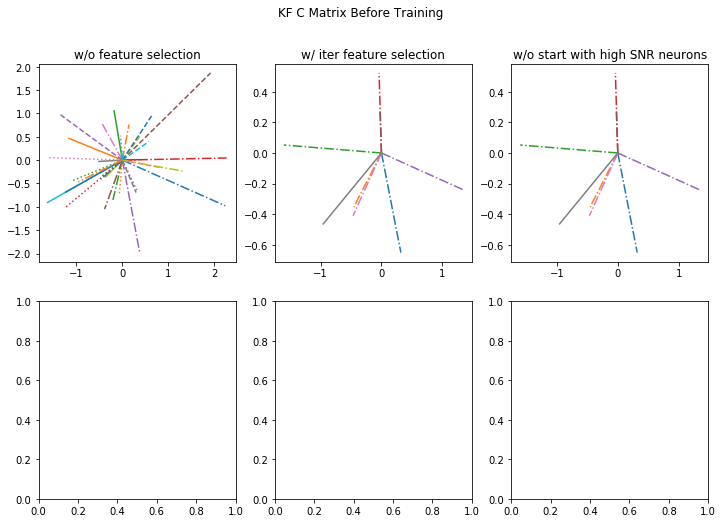

In [20]:
from afs_plotting import plot_prefered_directions

print('we replace the encoder using the weights')
print('assume, they are all randomly initialized get the first decoder')
print('get a handle to the first decoder')
first_decoder = exps_np[0].decoder
target_C = first_decoder.filt.C
target_Q = np.copy(first_decoder.filt.Q)

print()
diag_val = 5000
np.fill_diagonal(target_Q, diag_val)

print(target_Q)
    
#replace the decoder
for i,e in enumerate(exps):
    weights.change_target_kalman_filter_with_a_C_mat(e.decoder.filt, target_C, 
                                                     Q= target_Q, debug=False)
    e.select_decoder_features(e.decoder)
    e.record_feature_active_set(e.decoder)
    
print('we check the new decoder C matrix:')

figure_decoder_C, axs_decoder_C = plt.subplots(nrows=2, 
                               ncols=NUM_EXP, figsize = [GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP, GLOBAL_FIGURE_VERTICAL_SIZE * 2],squeeze = False)
figure_decoder_C.suptitle('KF C Matrix Before Training ')

for i,e in enumerate(exps):
    C = e.decoder.filt.C
    plot_prefered_directions(C, ax = axs_decoder_C[0,i])
    axs_decoder_C[0,i].set_title(exp_conds[i])

# Experiment run: assemble into a complete loop

##  define the function

In [21]:
#make this into a loop



def run_exp_loop(exp,  **kwargs):
        # riglib.experiment: line 597 - 601
    #exp.next_trial = next(exp.gen)
    # -+exp._parse_next_trial()np.arraynp.array


    # we need to set the initial state
    # per fsm.run:  line 138


    # Initialize the FSM before the loop
    exp.set_state(exp.state)
    
    finished_trials = exp.calc_state_occurrences('wait')
    print(f'finished: {finished_trials}')


    while exp.state is not None:

        # exp.fsm_tick()

        ### Execute commands#####
        exp.exec_state_specific_actions(exp.state)

        ###run the bmi loop #####
        # _cycle

        # bmi feature extraction, eh
        #riglib.bmi: 1202
        feature_data = exp.get_features()

        # Determine the target_state and save to file
        current_assist_level = exp.get_current_assist_level()
        target_state = exp.get_target_BMI_state(exp.decoder.states)

        # Determine the assistive control inputs to the Decoder
        #update assistive control level
        exp.update_level()
        if np.any(current_assist_level) > 0:
            current_state = exp.get_current_state()

            if target_state.shape[1] > 1:
                assist_kwargs = exp.assister(current_state, 
                                             target_state[:,0].reshape(-1,1), 
                                             current_assist_level, mode= exp.state)
            else:
                assist_kwargs = exp.assister(current_state, 
                                              target_state, 
                                              current_assist_level, 
                                              mode= exp.state)

            kwargs.update(assist_kwargs)
            
        

        # decode the new features
        # riglib.bmi.bmiloop: line 1245
        neural_features = feature_data[exp.extractor.feature_type]
        
        

        # call decoder.
        #tmp = exp.call_decoder(neural_features, target_state, **kwargs)
        neural_obs = neural_features
        learn_flag = exp.learn_flag
        task_state = exp.state

        n_units, n_obs = neural_obs.shape
        # If the target is specified as a 1D position, tile to match
        # the number of dimensions as the neural features
        if np.ndim(target_state) == 1 or (target_state.shape[1] == 1 and n_obs > 1):
            target_state = np.tile(target_state, [1, n_obs])

        decoded_states = np.zeros([exp.bmi_system.decoder.n_states, n_obs])
        update_flag = False

        for k in range(n_obs):
            neural_obs_k = neural_obs[:, k].reshape(-1, 1)
            target_state_k = target_state[:, k]

            # NOTE: the conditional below is *only* for compatibility with older Carmena
            # lab data collected using a different MATLAB-based system. In all python cases,
            # the task_state should never contain NaN values.
            if np.any(np.isnan(target_state_k)):
                task_state = 'no_target'

            #################################
            # Decode the current observation
            #################################
            unselected_decodable_obs, decode = exp.bmi_system.feature_accumulator(
                neural_obs_k)
            
            if exp.is_feature_change():
                #take care of the decoder selection stuff             
                
                decodable_obs = exp.select_features(unselected_decodable_obs)
            else:
                decodable_obs = unselected_decodable_obs.copy()
            
            if decode:  # if a new decodable observation is available from the feature accumulator
                prev_state = exp.bmi_system.decoder.get_state()

                exp.bmi_system.decoder(decodable_obs, **kwargs)
                # Determine whether the current state or previous state should be given to the learner
                if exp.bmi_system.learner.input_state_index == 0:
                    learner_state = exp.bmi_system.decoder.get_state()
                elif exp.bmi_system.learner.input_state_index == -1:
                    learner_state = prev_state
                else:
                    print(("Not implemented yet: %d" %
                           exp.bmi_system.learner.input_state_index))
                    learner_state = prev_state

                if learn_flag:
                    exp.bmi_system.learner(unselected_decodable_obs.copy(), learner_state, target_state_k, exp.bmi_system.decoder.get_state(
                    ), task_state, state_order=exp.bmi_system.decoder.ssm.state_order)

            decoded_states[:, k] = exp.bmi_system.decoder.get_state()

            ############################
            # Update decoder parameters
            ############################
            if exp.bmi_system.learner.is_ready():
                batch_data = exp.bmi_system.learner.get_batch()
                batch_data['decoder'] = exp.bmi_system.decoder
                
                #for feature selection
                unselected_batch = np.copy(batch_data['spike_counts'])
                selected_batch = np.copy(unselected_batch[exp._active_feat_set,:])
                batch_data['spike_counts'] = selected_batch.copy()
                
                kwargs.update(batch_data)
                exp.bmi_system.updater(**kwargs)
                exp.bmi_system.learner.disable()
                
                #measure features. 
                if isinstance(exp, FeatureSelector):
                    exp.measure_features(unselected_batch,
                                       batch_data['intended_kin'])
                

            new_params = None  # by default, no new parameters are available
            if exp.bmi_system.has_updater:
                new_params = copy.deepcopy(exp.bmi_system.updater.get_result())

            # Update the decoder if new parameters are available
            if not (new_params is None):
                exp.bmi_system.decoder.update_params(
                    new_params, **exp.bmi_system.updater.update_kwargs)
                new_params['intended_kin'] = batch_data['intended_kin']
                new_params['spike_counts_batch'] = batch_data['spike_counts']

                exp.bmi_system.learner.enable()
                update_flag = True

                # Save new parameters to parameter history
                exp.bmi_system.param_hist.append(new_params)
                
                #take care of the decoder selection stuff
                if exp.is_decoder_change():
                    #only select the first four neurons
                    print(f'decoder changes here at {exp.cycle_count}')
                    exp.select_decoder_features(exp.decoder, debug = True)
                
                #record the current feature active set
                exp.record_feature_active_set(exp.decoder)


        # saved as task data
        # return decoded_states, update_flag
        tmp = decoded_states
        exp.task_data['internal_decoder_state'] = tmp

        # reset the plant position
        # @riglib.bmi.BMILoop.move_plant  line:1254
        exp.plant.drive(exp.decoder)

        # check state transitions and run the FSM.
        current_state = exp.state

        # iterate over the possible events which could move the task out of the current state
        for event in exp.status[current_state]:
            # if the event has occurred
            if exp.test_state_transition_event(event):
                # execute commands to end the current state
                exp.end_state(current_state)

                # trigger the transition for the event
                exp.trigger_event(event)

                # stop searching for transition events (transition events must be
                # mutually exclusive for this FSM to function properly)
                break

        # sort out the loop params.
        # inc cycle count
        exp.cycle_count += 1

        # save target data as was done in manualControlTasks._cycle
        exp.task_data['target'] = exp.target_location.copy()
        exp.task_data['target_index'] = exp.target_index

        #done in bmi:_cycle after move_plant
        exp.task_data['loop_time'] = exp.iter_time()


        #fb_controller data
        exp.task_data['target_state'] = target_state

        #encoder data
        #input to this is actually extractor
        exp.task_data['ctrl_input'] = np.reshape(exp.extractor.sim_ctrl, (1,-1))

        #actually output
        exp.task_data['spike_counts'] = feature_data['spike_counts']
        exp.k_mat_params.append(np.copy(exp.decoder.filt.K))


        #save the decoder_state
        #from BMILoop.move_plant
        exp.task_data['decoder_state'] = exp.decoder.get_state(shape=(-1,1))
        
        #save bmi_data
        exp.task_data['update_bmi'] = update_flag


        # as well as plant data.
        plant_data = exp.plant.get_data_to_save()
        for key in plant_data:
            exp.task_data[key] = plant_data[key]

        # clda data handled in the above call.

        # save to the list hisory of data.
        exp.task_data_hist.append(exp.task_data.copy())
        
        #deal with the task count_down features
        
        if hasattr(exp, 'TOTAL_RUNNNING_TIME'):
            if exp.cycle_count == exp.total_frames:
                exp.state = None
                print('exit')
        
        #print out the trial update whenever wait count changes, alright. 
        if finished_trials != exp.calc_state_occurrences('wait'):
            finished_trials = exp.calc_state_occurrences('wait')
            print(f'finished trials :{finished_trials} with a current assist level of {exp.get_current_assist_level()}')


    if exp.verbose:
        print("end of FSM.run, task state is", exp.state)
    
    


## actually running the experiments

In [22]:
for i,e in enumerate(exps):
    np.random.seed(999)
    run_exp_loop(e, **kwargs_exps[i])
    print(f'Finished running  {exp_conds[i]}')
    print()
    print()

runseq
finished: 1
assist_level at final value after 0 successful trials


/home/sijia-aw/BMi3D_my/lab_bmi3d/riglib/bmi/kfdecoder.py:372: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  C = np.mat(np.linalg.lstsq(X.T, Y.T)[0].T)


finished trials :2 with a current assist level of 0.0
finished trials :3 with a current assist level of 0.0
finished trials :4 with a current assist level of 0.0
finished trials :5 with a current assist level of 0.0
finished trials :6 with a current assist level of 0.0
finished trials :7 with a current assist level of 0.0
finished trials :8 with a current assist level of 0.0
finished trials :9 with a current assist level of 0.0
finished trials :10 with a current assist level of 0.0
finished trials :11 with a current assist level of 0.0
finished trials :12 with a current assist level of 0.0
finished trials :13 with a current assist level of 0.0
finished trials :14 with a current assist level of 0.0
finished trials :15 with a current assist level of 0.0
finished trials :16 with a current assist level of 0.0
finished trials :17 with a current assist level of 0.0
finished trials :18 with a current assist level of 0.0
finished trials :19 with a current assist level of 0.0
finished trials :2

finished trials :152 with a current assist level of 0.0
finished trials :153 with a current assist level of 0.0
finished trials :154 with a current assist level of 0.0
finished trials :155 with a current assist level of 0.0
finished trials :156 with a current assist level of 0.0
finished trials :157 with a current assist level of 0.0
finished trials :158 with a current assist level of 0.0
finished trials :159 with a current assist level of 0.0
finished trials :160 with a current assist level of 0.0
finished trials :161 with a current assist level of 0.0
finished trials :162 with a current assist level of 0.0
finished trials :163 with a current assist level of 0.0
finished trials :164 with a current assist level of 0.0
finished trials :165 with a current assist level of 0.0
finished trials :166 with a current assist level of 0.0
finished trials :167 with a current assist level of 0.0
finished trials :168 with a current assist level of 0.0
finished trials :169 with a current assist level

decoder changes here at 41399
select_decoder_features: _change_one_flag = False
(16, 7)
(16, 7)
active feature set is [False False False False False False False False False False False False
 False False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
after trans: (17, 7)
after trans: (17, 17)
decoder change flag to false
decoder changes here at 41999
select_decoder_features: _change_one_flag = False
(17, 7)
(17, 7)
active feature set is [False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
after trans: (18, 7)
after trans: (18, 18)
decoder change flag to false
decoder changes here at 42599
select_decoder_features: _change_one_flag = False
(18, 7)
(18, 7)
active feature set is [False False False False False False False False False False False False
 False  True  True  True  True  True 

finished trials :85 with a current assist level of 0.0
finished trials :86 with a current assist level of 0.0
finished trials :87 with a current assist level of 0.0
finished trials :88 with a current assist level of 0.0
finished trials :89 with a current assist level of 0.0
finished trials :90 with a current assist level of 0.0
finished trials :91 with a current assist level of 0.0
finished trials :92 with a current assist level of 0.0
finished trials :93 with a current assist level of 0.0
finished trials :94 with a current assist level of 0.0
finished trials :95 with a current assist level of 0.0
finished trials :96 with a current assist level of 0.0
finished trials :97 with a current assist level of 0.0
finished trials :98 with a current assist level of 0.0
finished trials :99 with a current assist level of 0.0
finished trials :100 with a current assist level of 0.0
finished trials :101 with a current assist level of 0.0
finished trials :102 with a current assist level of 0.0
finishe

finished trials :31 with a current assist level of 0.0
finished trials :32 with a current assist level of 0.0
finished trials :33 with a current assist level of 0.0
finished trials :34 with a current assist level of 0.0
finished trials :35 with a current assist level of 0.0
finished trials :36 with a current assist level of 0.0
finished trials :37 with a current assist level of 0.0
finished trials :38 with a current assist level of 0.0
finished trials :39 with a current assist level of 0.0
finished trials :40 with a current assist level of 0.0
finished trials :41 with a current assist level of 0.0
finished trials :42 with a current assist level of 0.0
finished trials :43 with a current assist level of 0.0
finished trials :44 with a current assist level of 0.0
finished trials :45 with a current assist level of 0.0
finished trials :46 with a current assist level of 0.0
finished trials :47 with a current assist level of 0.0
finished trials :48 with a current assist level of 0.0
finished t

finished trials :179 with a current assist level of 0.0
finished trials :180 with a current assist level of 0.0
finished trials :181 with a current assist level of 0.0
finished trials :182 with a current assist level of 0.0
finished trials :183 with a current assist level of 0.0
finished trials :184 with a current assist level of 0.0
finished trials :185 with a current assist level of 0.0
finished trials :186 with a current assist level of 0.0
finished trials :187 with a current assist level of 0.0
finished trials :188 with a current assist level of 0.0
finished trials :189 with a current assist level of 0.0
finished trials :190 with a current assist level of 0.0
finished trials :191 with a current assist level of 0.0
finished trials :192 with a current assist level of 0.0
finished trials :193 with a current assist level of 0.0
finished trials :194 with a current assist level of 0.0
finished trials :195 with a current assist level of 0.0
exit
end of FSM.run, task state is None
Finished

# Postprocessing the data for loading

## declare defs and conventions

In [23]:
FRAME_RATE = 60
INT_WINDOW_TIME = 10 # s for looking at sample raw data

# some conventions as we go down the loop
X_VEL_STATE_IND = 3
Y_VEL_STATE_IND = 5
X_POS_STATE_IND = 0
Y_POS_STATE_IND = 2

state_indices = [X_POS_STATE_IND,
                 Y_POS_STATE_IND,
                 X_VEL_STATE_IND,
                 Y_VEL_STATE_IND]
state_names = ['x pos ', 'y pos', 'x vel', 'y vel']


INT_WIN_SAMPLES = INT_WINDOW_TIME * FRAME_RATE

## Refactor out the data

In [24]:
task_data_hist_np_all = [np.array(e.task_data_hist) for e in exps]
len(task_data_hist_np_all)
task_data_hist_np_all[0].dtype

dtype([('cursor', '<f8', (3,)), ('obs_t', '<f8', (32, 1)), ('KC', '<f8', (7, 7)), ('pred_state_mean', '<f8', (7, 1)), ('post_state_mean', '<f8', (7, 1)), ('pred_state_P', '<f8', (7, 7)), ('post_state_P', '<f8', (7, 7)), ('loop_time', '<f8', (1,)), ('decoder_state', '<f8', (7, 1)), ('internal_decoder_state', '<f8', (7, 1)), ('target_state', '<f8', (7, 1)), ('update_bmi', '<f8', (1,)), ('spike_counts', '<f8', (32, 1)), ('bin_edges', '<f8', (2,)), ('ctrl_input', '<f8', (7,)), ('assist_level', '<f8', (1,)), ('target', '<f8', (3,)), ('target_index', '<i4', (1,))])

## Finished time in seconds

In [25]:
finished_times_in_seconds = [(len(s)) for s in task_data_hist_np_all]
finished_times_in_seconds

[148175, 154857, 180000]

In [26]:
#calculate how many trials
for e in  exps: print(e.calc_state_occurrences('reward'))
print()

for e in  exps: print(e.calc_trial_num())

200
200
194

339
351
375


# Post data analysis

## Total finished trials

## Overall  trial statistics succuss rate)

[array([0., 0., 2., 3., 5., 3., 2., 2., 3., 2., 2., 1., 3., 4., 4., 0., 0.,
       3., 1., 5., 3., 2., 1., 3., 2., 2., 2., 4., 3., 2., 2., 2., 2., 2.,
       1., 2., 1., 3., 4., 3., 1., 3., 4., 2., 1., 4., 1., 1., 2., 2., 3.,
       4., 2., 0., 3., 4., 4., 4., 4., 3., 3., 1., 1., 3., 3., 4., 5., 2.,
       5., 2., 3., 4., 4., 1., 4., 2., 2., 1., 0., 1., 2., 2.])
 array([0., 0., 0., 1., 3., 3., 2., 2., 4., 3., 3., 3., 0., 1., 2., 2., 2.,
       2., 3., 1., 4., 1., 4., 0., 1., 0., 1., 1., 0., 1., 0., 3., 3., 2.,
       3., 4., 3., 1., 2., 5., 2., 3., 1., 4., 2., 2., 4., 1., 3., 2., 4.,
       1., 3., 3., 1., 3., 4., 1., 2., 3., 3., 3., 5., 4., 2., 2., 3., 5.,
       3., 4., 3., 3., 2., 2., 2., 4., 2., 4., 2., 4., 4., 3., 1., 1., 1.,
       2.])
 array([0., 0., 0., 1., 3., 3., 2., 2., 4., 3., 3., 3., 0., 1., 2., 2., 2.,
       2., 3., 1., 1., 2., 3., 1., 3., 3., 1., 2., 1., 2., 2., 2., 2., 1.,
       2., 1., 1., 2., 2., 3., 2., 3., 4., 2., 3., 2., 0., 1., 2., 1., 2.,
       2., 1., 2., 1.

ValueError: setting an array element with a sequence.

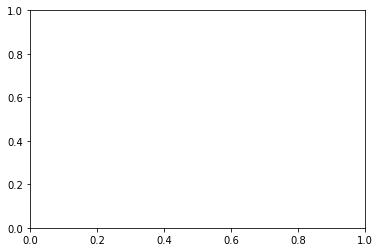

In [27]:
import behaviour_metrics
import importlib

importlib.reload(behaviour_metrics)

reward_events_per_minute = [behaviour_metrics.calc_event_rate_from_state_log(e.state_log,'reward',window_length=30) for e in exps]

reward_events_per_minute = np.array(reward_events_per_minute)

print(reward_events_per_minute)
plt.plot(reward_events_per_minute.T)

## sort into trials

In [ ]:
state_log = e.state_log
segmented_trials = behaviour_metrics.segment_trials_in_state_log(state_log)

In [ ]:
trial_dicts_all = []
dict_keys = ['cursor', #behaviour
             'ctrl_input', 'spike_counts', #encoder translates intended ctrl into spike counts
             'decoder_state']


for i in range(NUM_EXP):
    
    segmented_trials = behaviour_metrics.segment_trials_in_state_log(exps[i].state_log)

    task_data_hist_np = task_data_hist_np_all[i]
    trial_dict_0 = behaviour_metrics.sort_trials_use_segmented_log(segmented_trials, 
                               target_seq,
                               task_data_hist_np, dict_keys)
    
    trial_dicts_all.append(trial_dict_0)

for t in trial_dicts_all: print(len(t))

# Behaviour  analyses

## Trajectory analysis

In [ ]:
import afs_plotting
importlib.reload(afs_plotting)

In [ ]:
figure_trajectory, axes_trajectory = plt.subplots(1, NUM_EXP, figsize = (NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE, 
                                                  GLOBAL_FIGURE_VERTICAL_SIZE)) 


n_roi_trials = 0

CIRCLE_RADIUS = exps[0].target_radius

print(CIRCLE_RADIUS)

for i,axes in enumerate(axes_trajectory): 

    afs_plotting.add_center_out_grid(axes, target_seq, CIRCLE_RADIUS)
    
    
    sample_trial = trial_dicts_all[i][n_roi_trials]
    trial_cursor_trajectory = sample_trial['cursor']
    
    afs_plotting.plot_trial_trajectory(axes, trial_cursor_trajectory)

    axes.set_title(f'Trial {N_TRIALS} of {exp_conds[i]} ')



## Variance analysis

In [ ]:
importlib.reload(behaviour_metrics)

In [ ]:
arc_length = [behaviour_metrics.calc_arc_length_from_trial_dict(trial_dict) for trial_dict in trial_dicts_all]
for al in arc_length: plt.plot(al)
plt.legend(exp_conds)

# Kalman filter

## encoder

the job of the encoder is to directly encode intention into firing rates
the direct measure is just pearson correlation coefficients between 
the intentions and the firing rates

## decoder

In [ ]:
from afs_plotting import plot_prefered_directions

TEXT_OFFSET_VERTICAL = -0.2


figure_decoder_C.suptitle('KF C matrix before and after CLDA')

print('steady state tuning curves:')

for  i,e in enumerate(exps): 

    e = exps[i]
    C = e.decoder.filt.C

    plot_prefered_directions(C, ax = axs_decoder_C[1,i])
    axs_decoder_C[1,i].set_title(f'{exp_conds[i]}')

figure_decoder_C

## Decoder compared to the encoder



In [ ]:
import convergence_analysis
importlib.reload(convergence_analysis)
from convergence_analysis import calc_cosine_sim_bet_two_matrices, calc_cosine_to_target_matrix

active_feat_set = exps[2]._active_feat_set


for i,e in enumerate(exps):
    enc_directions = e.encoder.C
    dec_directions = np.array(e._used_C_mat_list)
    

    angles_hist = calc_cosine_to_target_matrix( dec_directions,enc_directions)
    
    if i == 0:
        active_angles = np.mean(angles_hist[:,noise_neuron_list], axis = 1)
        plt.plot(active_angles)
    
    active_angles = np.mean(angles_hist[:,active_feat_set], axis = 1)
    plt.plot(active_angles)
    


## looking at K matrix

In [ ]:
figure_k_matrix, axes_k_matrix = plt.subplots(2,NUM_EXP,
                                          figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * NUM_EXP,
                                                    GLOBAL_FIGURE_VERTICAL_SIZE * 2))

for i,e in enumerate(exps):
    K = (e._used_K_mat_list[1]).T

    plot_prefered_directions(K, ax  = axes_k_matrix[0, i])
    axes_k_matrix[0, i].set_title(exp_conds[i])

for i,e in enumerate(exps):
    K = (e._used_K_mat_list[-1]).T
    plot_prefered_directions(K, ax  = axes_k_matrix[1, i])
    axes_k_matrix[1,i].set_title(exp_conds[i])

In [ ]:
for i,e in enumerate(exps):
    
    enc_directions = e.encoder.C
    
    print(enc_directions.shape)
    K_mat = np.array(e._used_K_mat_list[1:])
    
    K_mat = np.swapaxes(K_mat, 1,2)
    print(K_mat.shape)
    
    if i == 0:
        angles_hist = calc_cosine_to_target_matrix(K_mat[:, no_noise_neuron_list,:], 
                                                   enc_directions[no_noise_neuron_list,:])
    else:
        angles_hist = calc_cosine_to_target_matrix(K_mat, enc_directions[e._active_feat_set,:])
    

    active_angles = np.mean(angles_hist, axis = 1)
    plt.plot(active_angles)

# Feature analysis

In [ ]:
from matplotlib import colors



fig_feature_active_map, axes_feat_active_map = plt.subplots(1, NUM_EXP,
                                                            figsize = ( NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE,
                                                                      GLOBAL_FIGURE_VERTICAL_SIZE),
                                                           sharey = True)
axes_feat_active_map[0].set_ylabel('Learner Batch number')

#color true to yellow
cmap = colors.ListedColormap(['white'])

for i, exp in enumerate(exps):

    active_feat_heat_map = np.array(exp._active_feat_set_list, dtype = np.int32)
    
    #https://stackoverflow.com/questions/40985961/matplotlib-how-to-change-data-point-color-based-on-its-boolean-value-consisten
    active_feat_heat_map = np.ma.masked_where(active_feat_heat_map == False, active_feat_heat_map)
    
    a = axes_feat_active_map[i].imshow(active_feat_heat_map, cmap = cmap)
    
    #color false to blue
    cmap.set_bad(color='black')
    
    axes_feat_active_map[i].set_xlabel('All features')
    axes_feat_active_map[i].set_title(exp_conds[i])


#fig_feature_active_map.colorbar(a, ax=axes_feat_active_map.ravel().tolist())

## Examine used K mat

## examine used C mat

In [ ]:
import weights_linear_regression
importlib.reload(weights_linear_regression)
from weights_linear_regression import calc_a_history_of_matrix_L2norms_along_first_axis


figure_weights_norm, axes_weights_norm = plt.subplots( NUM_EXP, N_TYPES_OF_NEURONS,
    figsize = (N_TYPES_OF_NEURONS * GLOBAL_FIGURE_VERTICAL_SIZE, NUM_EXP * GLOBAL_FIGURE_VERTICAL_SIZE))

C_mat_all = list()

for j,exp in enumerate(exps):
    
    updated_C_mat = np.array(exp._used_C_mat_list)
    the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(updated_C_mat, debug = False)

    C_mat_all.append(np.copy(updated_C_mat))
    axe_exp = axes_weights_norm[j,:]
    for i,a in enumerate(axe_exp):
        a.plot(the_history_of_KF_weights_in_time_by_neurons[:, neuron_type_indices_in_a_list[i]])
        a.set_xlabel('Batch number')
        a.set_ylabel('Weight')
        
C_mat_all = np.array(C_mat_all)

In [ ]:
fig_compr_means, axes_compr_means = plt.subplots(1, N_TYPES_OF_NEURONS,
                                                figsize = (GLOBAL_FIGURE_VERTICAL_SIZE * N_TYPES_OF_NEURONS,
                                                          GLOBAL_FIGURE_VERTICAL_SIZE),
                                                sharey = True)
selected_feature_set = no_noise_neuron_list
for i,a in enumerate(axes_compr_means):

    type_neuron_list = neuron_type_bool_list[i]
    
    for C in C_mat_all:


        the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(C, 
                                                                                                         target_C=e.encoder.C,
                                                                indices_to_sum=(X_VEL_STATE_IND, Y_VEL_STATE_IND))


        selected_neurons = np.logical_and(selected_feature_set, type_neuron_list)

        selected_mean = np.mean(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        std = np.std(the_history_of_KF_weights_in_time_by_neurons[:,selected_neurons], axis = 1)
        
        line = a.plot(selected_mean)
        
        x_data = np.arange((selected_mean).shape[0])
        
        
        a.fill_between(x_data ,selected_mean - std, selected_mean + std, alpha = 0.1 )
        a.legend(exp_conds)
        
handles, labels = a.get_legend_handles_labels()
fig_compr_means.legend(handles, labels, loc='lower center')
plt.show()
    
#axes_compr_means.set_title('Means of the high SNR weight trajectory')

## Fit to the begining for non feature selected

In [ ]:
# now, we can average over the neurons. 
from weights_linear_regression import calc_a_history_of_matrix_L2norms_along_first_axis

figure_weights_norm, axes_weights_norm = plt.subplots( 1, N_TYPES_OF_NEURONS,
    figsize = (N_TYPES_OF_NEURONS * GLOBAL_FIGURE_VERTICAL_SIZE, GLOBAL_FIGURE_VERTICAL_SIZE))


kf_C = np.copy(exps[0]._used_C_mat_list)

the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(kf_C, 
                                                                        indices_to_sum=(X_VEL_STATE_IND, Y_VEL_STATE_IND))


for i,a in enumerate(axes_weights_norm):
    a.plot(the_history_of_KF_weights_in_time_by_neurons[:,
                                                        neuron_type_indices_in_a_list[i]])
    a.set_xlabel('clda update times')
    

In [ ]:
from convergence_analysis import ExpFitAnalyzer, calc_flipped_shifted_exponential

#calculate this across neurons
exp_fit_analyzer = ExpFitAnalyzer()

fig_fit, ax_fit = plt.subplots(4,8, figsize = (32,16))

unfitted_list = list()
fitting_params = list()


x_data = np.arange(the_history_of_KF_weights_in_time_by_neurons.shape[0])

for i,ax in enumerate(ax_fit.flat):
    kf_series_temp = the_history_of_KF_weights_in_time_by_neurons[:,i]
    
    try:
    
        (fitting_param_temp, var) = exp_fit_analyzer.calc_fitting_params(calc_flipped_shifted_exponential, x_data, kf_series_temp)
        
        exp_fit_analyzer.calc_estimated_y()
        exp_fit_analyzer.plot_fitting(ax)
    
    except:
        unfitted_list.append(i)
        fitting_param_temp = np.array([0, 0])
        
    fitting_params.append(fitting_param_temp)
    

In [ ]:
fitting_params = np.array(fitting_params)
fitting_params

In [ ]:
fitting_params_all_exps = list()

for e in exps:

    kf_C = np.copy(e._used_C_mat_list)

    the_history_of_KF_weights_in_time_by_neurons = calc_a_history_of_matrix_L2norms_along_first_axis(kf_C, 
                                                                            indices_to_sum=(X_VEL_STATE_IND, Y_VEL_STATE_IND))

    x_data = np.arange(the_history_of_KF_weights_in_time_by_neurons.shape[0])
    
    fitting_params = []

    for i in range(N_NEURONS):
        kf_series_temp = the_history_of_KF_weights_in_time_by_neurons[:,i]

        try:

            (fitting_param_temp, var) = exp_fit_analyzer.calc_fitting_params(calc_flipped_shifted_exponential, x_data, kf_series_temp)

        except:
            unfitted_list.append(i)
            fitting_param_temp = np.array([0, 0])

        fitting_params.append(fitting_param_temp)
    
    #processing
    fitting_params = np.array(fitting_params)
    fitting_params_all_exps.append(fitting_params)

len(fitting_params_all_exps)

In [ ]:
fit_params 